# Анализ результатов A/B/C теста, а также A/B теста сегментированных пользователей

<hr>

## 1 A/B/C тест
Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами тестов:  

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались  
либо прямоугольные,  
либо новые квадратные  

Примите решение: какие картинки в итоге будем использовать?

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия.  
Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

In [33]:
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (16, 6)})

In [34]:
pic = pd.read_csv('5_task_1.csv')
pic.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


id – id клиента в эксперименте  
group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)  
events – сколько блюд суммарно было заказано за период

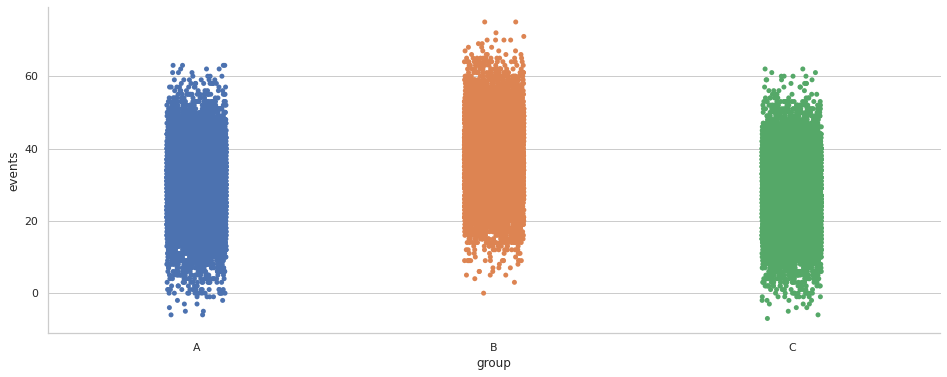

In [35]:
sns.stripplot(data=pic, x='group', y='events')
sns.despine()

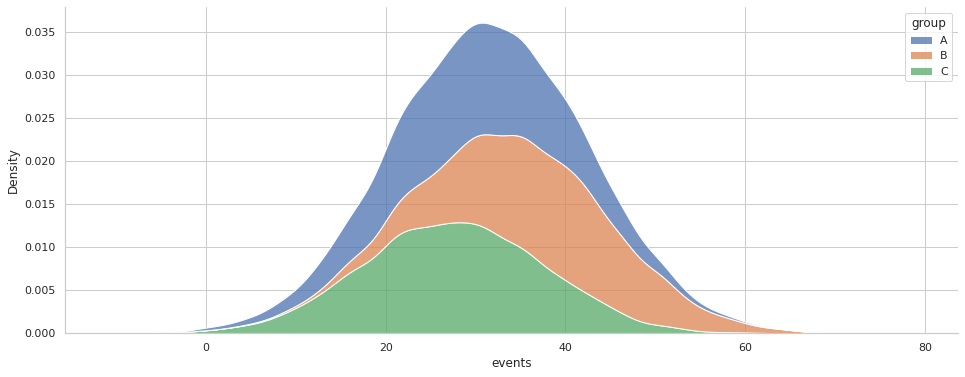

In [36]:
sns.kdeplot(data=pic, x='events', hue='group', multiple="stack")
sns.despine()

Проверим являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [37]:
pg.homoscedasticity(data=pic, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


p-value > 0.05, не отклоняем нулевую гипотезу

Убедимся, что данные распределены нормально. Сравним результат с qq-графиками.

In [38]:
print('размер выборки:', pic.shape[0])

размер выборки: 30000


так как выборка больше 5000, тест Шапиро не подходит. Мы использовали Normaltest

In [39]:
pg.normality(data=pic, dv='events', group='group', method='normaltest')

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


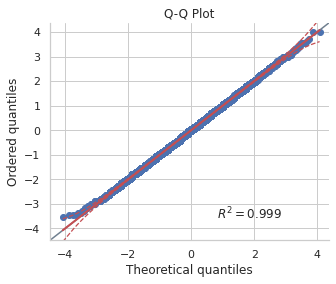

In [40]:
pg.qqplot(pic.events)
sns.despine()

Самое время провести тест!

In [41]:
model = smf.ols(data=pic, formula='events ~ C(group)').fit()
result_anova = anova_lm(model)
result_anova

,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,5.729361e+05,286468.062300,2886.166657,0.0
Residual,29997.0,2.977369e+06,99.255551,NaN,NaN


In [42]:
print('Значение статистики равно {}, а р-уровень значимости составил {}' \
      .format(round(result_anova[:'C(group)'].F[0]), round(result_anova[:'C(group)']['PR(>F)'][0])))

Значение статистики равно 2886, а р-уровень значимости составил 0


Используя критерий Тьюки и определим, между какими группами есть статистически значимые различия.

In [43]:
result_tukey = pairwise_tukeyhsd(pic.events, pic.group).summary()
result_tukey

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [44]:
for i in result_tukey:
    if i != result_tukey[0]:
        print('сравнивая {} и {} различия={}'.format(i[0], i[1], i[-1]))

сравнивая A и B различия=True
сравнивая A и C различия=True
сравнивая B и C различия=True


In [45]:
pg.pairwise_tukey(data=pic, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


In [46]:
means = pic.groupby('group').agg({'events': 'mean'})
print('В итоге будем использовать', means[means.events == means.max()[0]].index[0])

В итоге будем использовать B


<hr>

## 2 A/B тест сегментированных пользователей

К вам пришел коллега с результатами тестов:  
была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый  

Коллега пришел к вам с просьбой:   
он посмотрел на графики и предположил, что среди групп могут встретиться различия.  

Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

In [47]:
but = pd.read_csv('5_task_2.csv')
but.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


id – id клиента в эксперименте  
segment – сегмент (high/low)  
group – вид кнопки (control – старая версия, test – новая версия)  
events – сколько блюд суммарно было заказано за период  

In [48]:
but['combination'] = but['group'] + '/' + but['segment']
but.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high
3,50399,test,high,80.0,test/high
4,95613,test,high,78.0,test/high


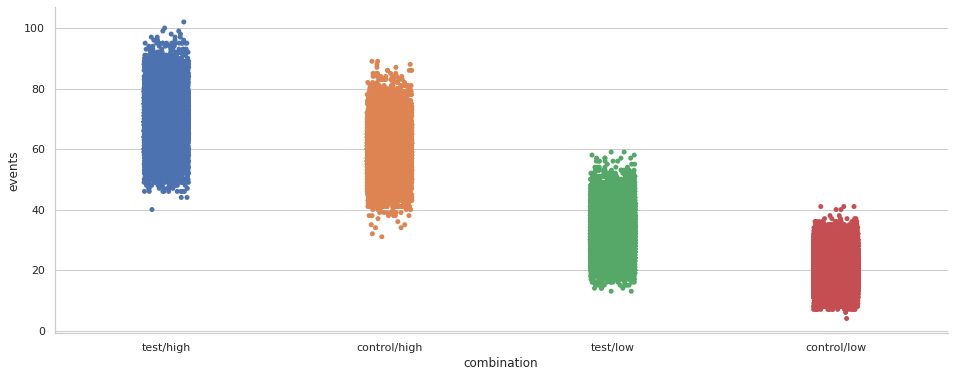

In [49]:
sns.stripplot(data=but, x='combination', y='events')
sns.despine()

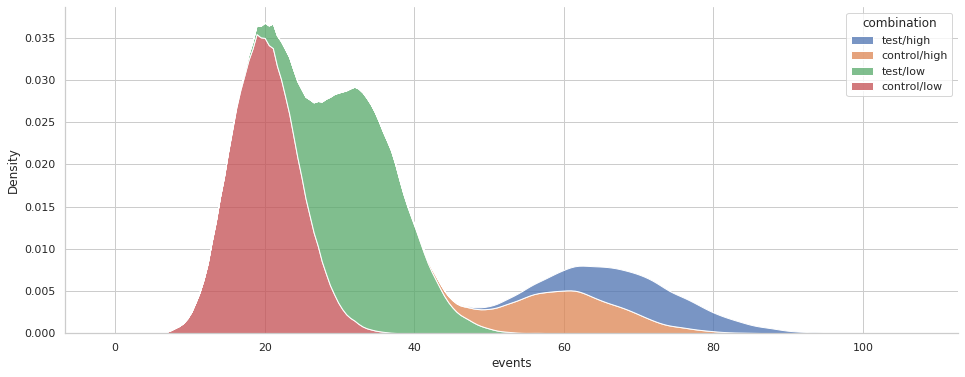

In [50]:
sns.kdeplot(data=but, x='events', hue='combination', multiple="stack")
sns.despine()

Посмотрим на данные.  
Для начала визуализируем распределение events для контрольной и тестовой групп.  
Соотнесём графики распределения и экспериментальные группы:

In [51]:
test = but[but.group == 'test']
control = but[but.group == 'control']
high = but[but.segment == 'high']
low = but[but.segment == 'low']

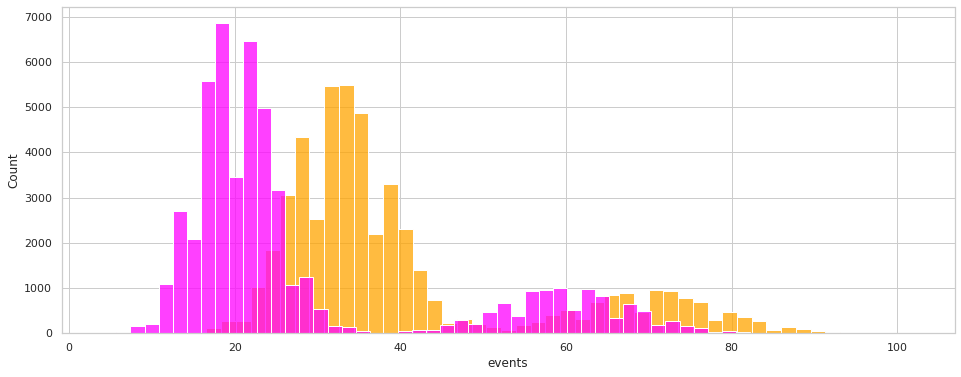

In [52]:
sns.histplot(data=test, x='events', bins=50, color='orange', label='test')
sns.histplot(data=control, x='events', bins=50, color='magenta',label='control');

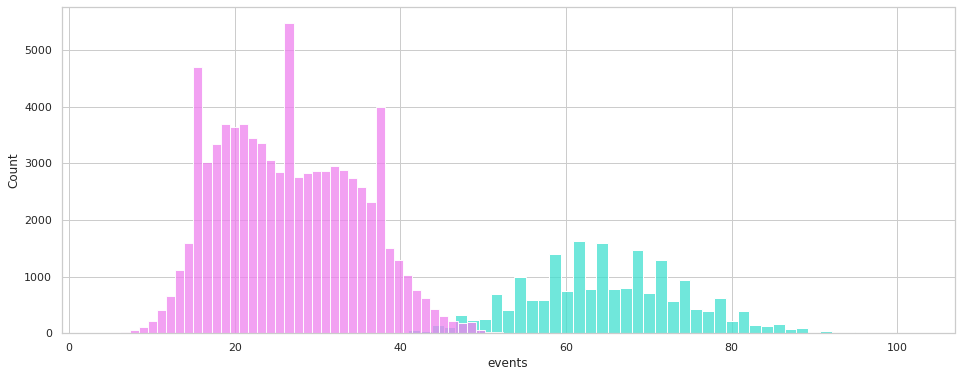

In [53]:
sns.histplot(data=high, x='events', bins=50, color='turquoise')
sns.histplot(data=low, x='events', bins=50, color='violet');

Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя.  

In [54]:
but.groupby(['group', 'segment']).agg({'events':['median', 'std']}).round(2)

events      
                median   std
group   segment             
control high      60.0  7.81
        low       20.0  4.47
test    high      70.0  8.40
        low       33.0  5.72

Осталось выбрать формулу для модели.  
Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

Проведём тест через anova_lm, а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.  
В данном случае для последующих сравнений между группами соединим колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey

In [55]:
model = smf.ols(data=but, formula='events ~ C(group)*C(events)').fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,3.837195e+06,3.837195e+06,1.878777e+32,0.0
C(events),96.0,2.708639e+07,2.821499e+05,1.381469e+31,0.0
C(group):C(events),96.0,4.351724e-22,4.533045e-24,2.219480e+02,0.0
Residual,99826.0,2.038837e-21,2.042391e-26,NaN,NaN


In [56]:
model = smf.ols(data=but, formula='events ~ C(group)*C(events)').fit()
anova_lm(model, typ=2)

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 96, but rank is 79
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 96, but rank is 89
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
C(group),-9.084875e-10,1.0,-4.448158e+16,1.0
C(events),3.723171e+07,96.0,1.898904e+31,0.0
C(group):C(events),9.183533e+03,96.0,4.683815e+27,0.0
Residual,2.038837e-21,99826.0,NaN,NaN


In [57]:
pg.anova(data=but, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [58]:
but_tukey = pairwise_tukeyhsd(but.events, but.combination).summary()
but_tukey

group1,group2,meandiff,p-adj,lower,upper,reject
control/high,control/low,-39.9392,0.001,-40.1073,-39.7711,True
control/high,test/high,9.9677,0.001,9.7551,10.1803,True
control/high,test/low,-26.9449,0.001,-27.113,-26.7768,True
control/low,test/high,49.9069,0.001,49.7388,50.075,True
control/low,test/low,12.9944,0.001,12.888,13.1007,True
test/high,test/low,-36.9126,0.001,-37.0807,-36.7445,True


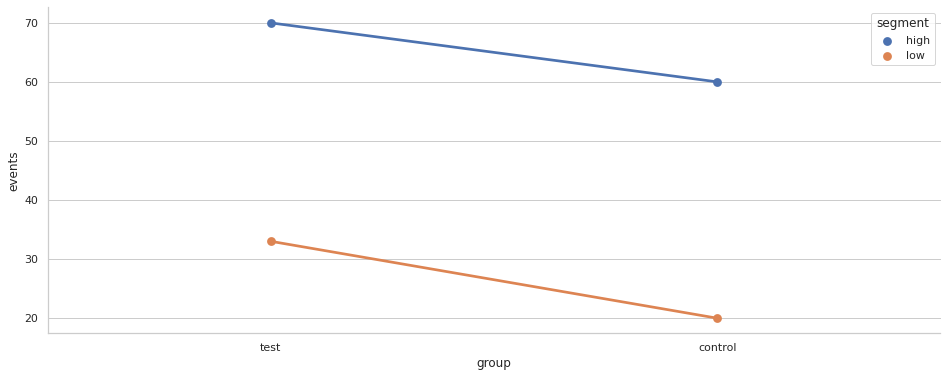

In [59]:
sns.pointplot(data=but, x='group', y='events', hue='segment')
sns.despine()

Фактор group оказался значимым, фактор segment значимый, их взаимодействие – значимо

Судя по графику, для всех групп среднее значение events увеличилось

Решение: выкатываем новую версию